# Prepare the train/val/test dataset

First we import the necessary python modules and set the matplotlib parameters

In [4]:
import os
import numpy as np
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from dti_util import code_dam, decode_dam, stack_training, unstack_training

# Change default matplotlib
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1
mpl.rcParams['axes.labelsize']=mpl.rcParams['axes.titlesize']

First, we define all the parameters of the numerical experiment

In [5]:
# Name of the experiment
name = 'demo'

# Root of all directory used
rootdir = '/mnt/sfe-ns9602k/Julien/data'

# Directory containing the input data
datadir = os.path.join(rootdir,'anton/shom5km_defor_4cnn')

# Directory where to save the data
traindir = os.path.join(rootdir,'train')

# Features used as predictors
colnames = ('log_deformation_0',)

# Other feture used (e.g. for masking)
othernames = ('h',)

# Thresholds used for masking
th_sit = 0.9 # Sea ice concentration threshold
th_dam = 0.8 # Damage threshold

# Value to use in the normalization
epsi=1e-2

## 1. Load the dataset

We define the list of files used in the dataset:

In [6]:
# the sorted function should list the images in chronological order
lfiles=list(map(os.path.basename,sorted(glob.glob(os.path.join(datadir,'field*.npz')))))
n = len(lfiles)
print(f'{n} files found')

529 files found


The first file only is loaded to set the dimension of the images

In [7]:
# Load the first sample
sample0 = np.load(os.path.join(datadir,lfiles[0]))

# Take for example the damage field
dam0 = sample0['d']

# Set the dimension of the field as (ny, nx)
ny, nx = dam0.shape


The target $y$ of the model are first normalized following the following formula:
$$
y_{n} = \log_{10} (1 - y + \epsilon),
$$
where $y_n$ is the normalized damage value, $\log_{10}$ is the logaritthm function in base 10, and $\epsilon$ is a parameter (set in the experiment parameters as ```epsi```).
    
Then the the normalized value is standardized between -1 and 1 to be used as target for the training:
$$
y_s = 2 \frac{y_n - a}{b-a} - 1,
$$
where a (resp. b) is the minimum (resp. maximum) value reached by $y_n$ which depend on the experiment parameters (```epsi``` and the damage threshold ```th_dam```):  
```a=np.log10(epsi)```  
```b=np.log10(1-th_dam+epsi)```

We define the normalization function (compute $y_s$ from $y$) and the denormalization function (compute $y$ from $y_s$)

In [8]:
# Normalization function
norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)

# Denormalization function
denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)

We load the files

In [9]:
# Name of the features to be loaded
allcols = colnames+othernames

#number of channel (number of predictive features)
nc = len(colnames) 

#number of other features used for masking, diag but not as predictive features
no = len(othernames)

# Initalize the feature matrix Xall and the target matrix target
Xall = np.empty((n,ny,nx,nc+no))
target = np.empty((n,ny,nx))

# Loop over all the files
for i in tqdm(range(n)):
    sample = np.load(os.path.join(datadir,lfiles[i]))
    
    # Extract the target (damage) and normalize it
    target[i,:,:] = norm(sample['d'])
    
    # Loop over the features
    for ic,c in enumerate(allcols):
        
        # Some features are extracted with preprocessing
        if c == 'log_deformation_0':
            #Compute the deformation in d-1 (initially in s-1) in log
            
            xx = np.log10(24 * 60 * 60 * np.hypot(sample['e1_0'], sample['e2_0']))
            
        # Other features are directly extracted from the file
        else:
            xx = sample[c]
        Xall[i,:,:,ic] = xx
# Predictive features            
X = Xall[...,:nc]

# Target
target = target

# Other features
Xother = Xall[...,nc:]

# Running this cell will trigger a warning when log10 is computed on low and nan values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Let's check if the files have consistent size

In [10]:
print (f'Shape of the input features: {X.shape}')
print (f'Shape of the target features: {target.shape}')

Shape of the input features: (529, 400, 500, 1)
Shape of the target features: (529, 400, 500)


We create a pixel-wise mask for the input features and the target :
- All the input features that have a valid numerical values are kept (value of the mask = 1)
- All the target that have valid numerical values and correspond to pixels above the threshold defined for the experiment are kept (value of the mask = 1)

In [11]:
# Create the valid numerical values mask
mask_num = np.all( (np.isfinite(Xall)) & (np.isfinite(target[...,np.newaxis])),axis=3)

# Create the sea-ice thickness mask
ih = othernames.index('h') # Index of the sea ice concentration field
mask_sit = Xother[...,ih]> th_sit

# Create the damage mask
mask_dam = denorm(target) > th_dam

# Compile all the mask together
mask_all = mask_num & mask_sit & mask_dam
mask_in = mask_num

# Running this cell will trigger warning due to nan values in the comparison with threshold values


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


Print and plot a summary of the masking procedure

In [12]:
# Total number of pixels
ntot = mask_all.shape[0]*mask_all.shape[1]*mask_all.shape[2]

print (f'Shape of the input mask: {mask_in.shape}')
print (f'Shape of the target mask: {mask_all.shape}')

print (f'Total number of pixel:{ntot} on {n} images')
print (f'Total of valid numerical values:{mask_num.sum()} ({100*mask_num.sum()/ntot:.1f}%)')
print (f'Total of sit above the threshold:{mask_sit.sum()} ({100*mask_sit.sum()/ntot:.1f}%)')
print (f'Total of damage above the threshold:{mask_dam.sum()} ({100*mask_dam.sum()/ntot:.1f}%)')
print (f'Total of valid input:{mask_in.sum()} ({100*mask_in.sum()/ntot:.1f}%)')
print (f'Total of valid target:{mask_all.sum()} ({100*mask_all.sum()/ntot:.1f}%)')


Shape of the input mask: (529, 400, 500)
Shape of the target mask: (529, 400, 500)
Total number of pixel:105800000 on 529 images
Total of valid numerical values:96064332 (90.8%)
Total of sit above the threshold:68261684 (64.5%)
Total of damage above the threshold:54332552 (51.4%)
Total of valid input:96064332 (90.8%)
Total of valid target:48139787 (45.5%)


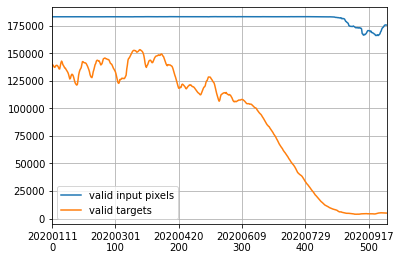

In [13]:
# Total of valid pixel by date
fig, ax = plt.subplots()
ax.plot(mask_in.sum(axis=(1,2)), label='valid input pixels')
ax.plot(mask_all.sum(axis=(1,2)), label='valid targets')
ax.set_xlim((0,n))
ax.get_xticks().tolist()
ax.set_xticklabels([lfiles[int(i)][6:14]+'\n{:d}'.format(int(i)) for i in ax.get_xticks().tolist() if i<n]);
ax.legend();
ax.grid()

## 1. Few plots of the data


We arbitrarly chose 4 samples to plot

In [14]:
# Index of chosen images
iplot = [0,11,100,400]

#Put the values in dedicated variables to be plotted
xx = X[iplot,...,0]
yy0 = target[iplot]
ww = mask_all[iplot]

# Mask incorrect values with nans
xx[~mask_in[iplot]]= np.nan
yy0[~ww] = np.nan

print('Dates of the chosen images')
for i in iplot:
    print(lfiles[i][6:17])


Dates of the chosen images
20200111T00
20200116T12
20200301T00
20200729T00


For each selected sample, plot the deformation, the damage and the mask

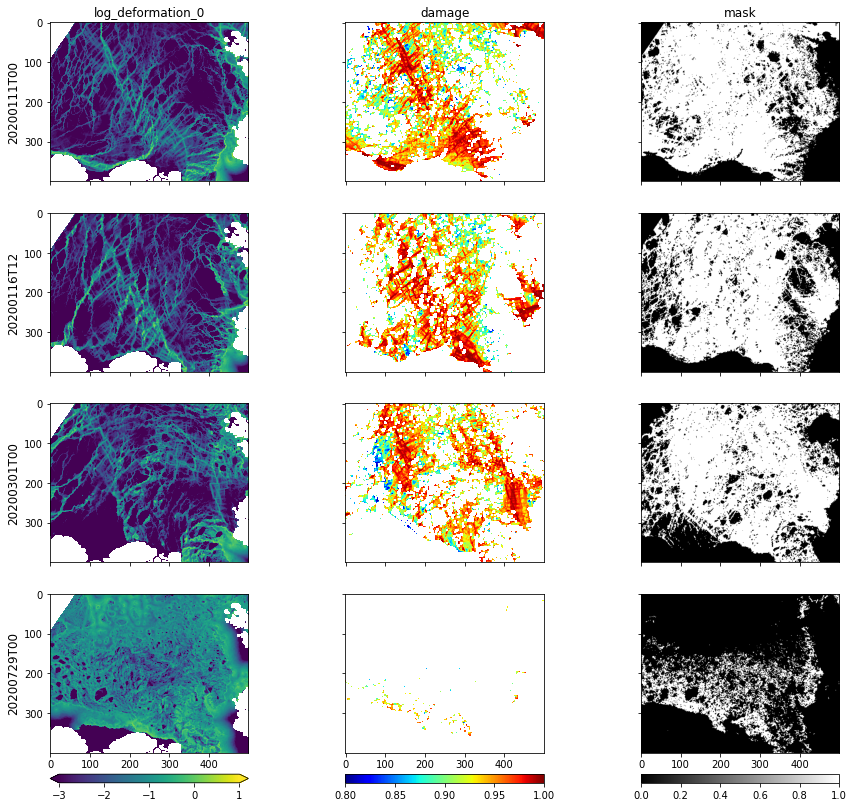

In [15]:
#fig = plt.figure(figsize=(15,3*len(iplot)))
fig, ax = plt.subplots(nrows=len(iplot), ncols=3,sharex='all', sharey='all', figsize=(15,3*len(iplot)))
fig.subplots_adjust(bottom=0.035)
c = dict()
for iy in range(len(iplot)):
    c[0] = ax[iy,0].imshow(xx[iy],vmin=-3, vmax=1)
    c[1] = ax[iy,1].imshow(denorm(yy0[iy]), vmin=th_dam,vmax=1.,cmap='jet')
    c[2] = ax[iy,2].imshow(ww[iy],cmap='gray', vmin=0, vmax=1)
    ax[iy,0].set_ylabel(lfiles[iplot[iy]][6:17])
ax[0,0].set_title(colnames[0]);
ax[0,1].set_title('damage');
ax[0,2].set_title('mask');
cbar_ax = dict()
lextend = ['both','neither','neither']
for i in range(3):
    pos = ax[3,i].get_position()
    left = pos.extents[0]
    width = pos.extents[2] - pos.extents[0]
    cbar_ax[i] = fig.add_axes([left, 0., width, 0.01])
    fig.colorbar(c[i], cax=cbar_ax[i], orientation='horizontal', extend=lextend[i])




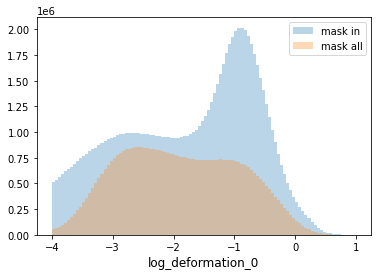

In [16]:
bins = 100

# Set the limits for the features variables
lims = {
    'log_deformation_0': (-4, 1)
}

fig, ax = plt.subplots(nrows=nc, squeeze = False)

for i in range(nc):
    ax[i,0].hist(X[mask_in[...],i].ravel(), bins,  lims[colnames[i]], alpha=0.3, label='mask in')
    ax[i,0].hist(X[mask_all[...],i].ravel(), bins,  lims[colnames[i]], alpha=0.3, label='mask all')

    ax[i,0].set_xlabel(colnames[i])
    ax[i,0].legend()


We also look at the effect of the normalization

Text(0.5, 0, 'Damage (normalized)')

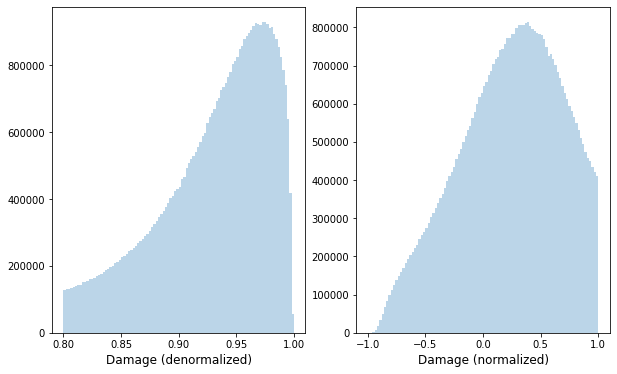

In [17]:
bins = 100

fig,ax = plt.subplots(ncols=2,figsize=(10,6))

dd = target[mask_all].ravel()
lims = [norm(1),norm(th_dam)]

ax[0].hist(denorm(dd),bins,(th_dam, 1), alpha=0.3)
ax[0].set_xlabel('Damage (denormalized)')
ax[1].hist(dd, bins,  lims, alpha=0.3, label='Damage (coded)')
ax[1].set_xlabel('Damage (normalized)')


## 3. Make the train/test dataset


In [19]:
# Transform big images to smaller ones for training
start_train = 10
end_train = 300
mask_in2 = mask_in[start_train:end_train]
mask_all2 = mask_all[start_train:end_train]
X2 = X[start_train:end_train]
y2 = target[start_train:end_train]
ntrain = X2.shape[0]
Xtrain, ytrain, mask_train = stack_training(X2, y2, mask_in2, mask_all2, dsize=25, strides=20)

In [17]:
np.savez(os.path.join(traindir,'train.npz'),Xtrain=Xtrain, ytrain=ytrain, mask_train=mask_train, shape_original=(ntrain,ny,nx))

162770
111946
105957


In [46]:
# Test image
itest = 0
mask_in2 = mask_in[itest:itest+1]
mask_all2 = mask_all[itest:itest+1]
X2 = X[itest:itest+1]
y2 = target[itest:itest+1]
X2[~mask_in2]=np.nan
y2[~mask_in2]=np.nan

X1, y1 = im2tile(X2,y2, strides=1)
X2r, y2r, = tile2im(X1,y1, strides= 1)
nn,ny,nx,nc = X2.shape
X1.shape, y1.shape, y2.shape

1 400 500 1
376 476
(178976, 25, 25, 1)
1 376 476


((178976, 25, 25, 1), (178976, 1), (1, 400, 500, 1))

In [47]:
mask_train_in =  np.all(np.isfinite(X1),axis=(1,2,3)) 
print(mask_train_in.sum())
mask_train_out =  np.all(np.isfinite(y1),axis=(1)) 
print(mask_train_out.sum())
mask_train = mask_train_in & mask_train_out
print(mask_train.sum())

154300
168563
154300


In [48]:
print(mask_train.shape,mask_train.sum())
Xtrain = X1[mask_train,:]
ytrain = y1[mask_train,0]
print(Xtrain.shape, ytrain.shape)
np.savez(os.path.join(traindir,'test.npz'),Xtrain=Xtrain, ytrain=ytrain, mask_train=mask_train, shape_original=(nn,ny,nx))

(178976,) 154300
(154300, 25, 25, 1) (154300,)


In [15]:
def test_custom_loss(dummy, XX, yy):
    """Test if the Keras model has a cost of zeros over the masked pixels
    """
    mask = yy[...,1:]==0
    weights = yy[...,1:]>0
    eval1 = dummy.evaluate(XX, yy, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][mask[...,0]] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff1 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval2 = dummy.evaluate(XX, yy_bis, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][weights[...,0].astype('bool')] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff2 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval3 = dummy.evaluate(XX, yy_bis, batch_size=20)

    assert diff1>0
    assert eval1 == eval2
    assert diff2 >2
    assert eval1 != eval3
    return 0

In [ ]:
test_custom_loss(dummy, X[:20],target_weighted[:20])
